In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn import metrics, preprocessing

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# сразу напишем код функции, которая будет вычислять все нужные метрики

def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'RMSE:  {round(RMSE,4)}\n  R2: {round(R2,4)}\n Adjusted R2: {round(adjusted_r2, 4)}\n Cross Validated R2: {round(cv_score.mean(),4)}')
    return R2, adjusted_r2, CV_R2, RMSE

# Регрессия

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CarPrice_Assignment.csv")

Mounted at /content/drive/


## Разведочный анализ и предобработка данных

In [4]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [5]:
df.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [7]:
def obj_in_int(df):
  for column in df:
    if df[column].dtype == 'O':
      df[column] = df[column].astype('category').cat.codes

In [8]:
obj_in_int(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    int16  
 3   fueltype          205 non-null    int8   
 4   aspiration        205 non-null    int8   
 5   doornumber        205 non-null    int8   
 6   carbody           205 non-null    int8   
 7   drivewheel        205 non-null    int8   
 8   enginelocation    205 non-null    int8   
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    int8   
 15  cylindernumber    205 non-null    int8   
 16  enginesize        205 non-null    int64  
 1

In [9]:
df.symboling = df.symboling + 2
df.describe()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,2.834146,77.209756,0.902439,0.180488,0.439024,2.614634,1.326829,0.014634,98.756585,...,126.907317,3.253659,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,41.014583,0.297446,0.385535,0.497483,0.859081,0.556171,0.120377,6.021776,...,41.642693,2.013204,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.600000,...,61.000000,0.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,2.000000,44.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,94.500000,...,97.000000,1.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,3.000000,80.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,97.000000,...,120.000000,5.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,4.000000,115.000000,1.000000,0.000000,1.000000,3.000000,2.000000,0.000000,102.400000,...,141.000000,5.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,5.000000,146.000000,1.000000,1.000000,1.000000,4.000000,2.000000,1.000000,120.900000,...,326.000000,7.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


## Модели регрессии

In [26]:
X = df.drop(['price', 'car_ID'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)


from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.fit_transform(X_test), columns=X_test.columns)

In [27]:
X_train.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,0.00,0.861111,1.0,0.0,0.0,0.75,1.0,0.0,0.495385,0.697015,...,0.500000,0.445344,0.714286,0.349515,0.585859,0.13750,0.450000,0.567568,0.181818,0.216216
1,0.50,0.548611,1.0,0.0,1.0,0.75,0.5,0.0,0.187692,0.361194,...,0.333333,0.145749,0.142857,0.233010,0.555556,0.15000,0.087500,0.567568,0.515152,0.567568
2,0.25,0.569444,0.0,1.0,0.0,0.75,1.0,0.0,0.600000,0.680597,...,0.333333,0.368421,0.428571,0.766990,0.671717,0.87500,0.195833,0.000000,0.424242,0.459459
3,0.00,0.784722,1.0,0.0,0.0,0.75,0.5,0.0,0.430769,0.514925,...,0.333333,0.246964,0.714286,0.388350,0.681818,0.10625,0.183333,0.027027,0.454545,0.486486
4,0.75,0.937500,1.0,0.0,0.0,0.75,0.5,0.0,0.273846,0.456716,...,0.333333,0.194332,0.714286,0.271845,0.611111,0.12500,0.154167,0.594595,0.393939,0.486486


In [28]:
X_train.describe()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.458042,0.509081,0.902098,0.188811,0.426573,0.657343,0.657343,0.020979,0.321463,0.491462,...,0.346154,0.266527,0.469530,0.425012,0.537985,0.190953,0.233829,0.517483,0.334817,0.395766
std,0.302551,0.279235,0.298227,0.392734,0.496318,0.219391,0.280967,0.143818,0.191158,0.184201,...,0.102925,0.151074,0.290019,0.253954,0.158989,0.246008,0.164846,0.242013,0.191597,0.181739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.295139,1.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.187692,0.376119,...,0.333333,0.149798,0.142857,0.233010,0.464646,0.093750,0.091667,0.351351,0.151515,0.243243
50%,0.500000,0.513889,1.000000,0.000000,0.000000,0.750000,0.500000,0.000000,0.261538,0.479104,...,0.333333,0.238866,0.714286,0.417476,0.555556,0.125000,0.195833,0.513514,0.303030,0.378378
75%,0.750000,0.746528,1.000000,0.000000,1.000000,0.750000,1.000000,0.000000,0.430769,0.616418,...,0.333333,0.344130,0.714286,0.655340,0.616162,0.150000,0.283333,0.729730,0.454545,0.486486
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Линейная регрессия

In [29]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
modelLR = LinearRegression()

# Fit the model to the data
modelLR.fit(X_train, y_train)

# Predict the response for a new data point
y_pr_LR = modelLR.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelLR, X_train, y_train, X_test, y_test, y_pr_LR)

RMSE:  4307.1584
  R2: 0.7269
 Adjusted R2: 0.5497
 Cross Validated R2: 0.7684


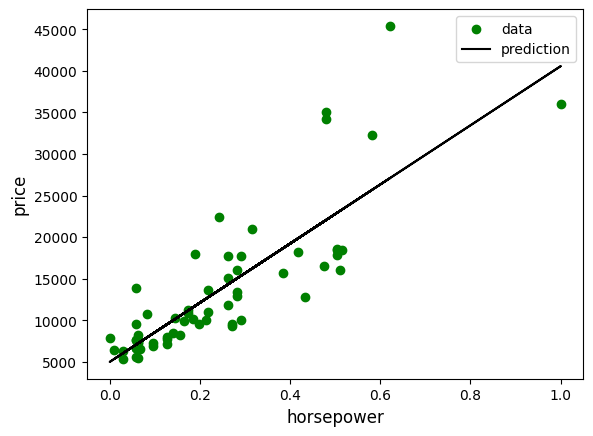

In [30]:
X2 = X_test["horsepower"].values[:,np.newaxis]
y2 = y_test.values

model2 = LinearRegression()
model2.fit(X2, y2)

plt.scatter(X2, y2, color='g', label='data')
plt.plot(X2, model2.predict(X2), color='k', label='prediction')


plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

### Полиномиальная регрессия

In [31]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=5)

poly_features = poly.fit_transform(X)
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(poly_features, y, test_size=0.3, random_state=15)

# Create a linear regression model
modelPR = LinearRegression()

# Fit the model to the data
modelPR.fit(X_p_train, y_p_train)

# Predict the response for a new data point
y_pr_PR = modelPR.predict(X_p_test)

_ = Reg_Models_Evaluation_Metrics(modelPR, X_p_train, y_p_train, X_p_test, y_p_test, y_pr_PR)

RMSE:  537426.0159
  R2: -4251.0794
 Adjusted R2: 3.1853
 Cross Validated R2: -319.5


Метрики плохии, модель не подходит для прогнозирования

### Регрессия дерева принятия решений

In [76]:
from sklearn.tree import DecisionTreeRegressor

# Create a stepwise regression model
modelDT = DecisionTreeRegressor(max_depth=2)

# Fit the model to the data
modelDT.fit(X_train, y_train)

# Predict the response for a new data point
y_dt_pred = modelDT.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelDT, X_train, y_train, X_test, y_test, y_dt_pred)

RMSE:  2871.8544
  R2: 0.8786
 Adjusted R2: 0.7998
 Cross Validated R2: 0.6737


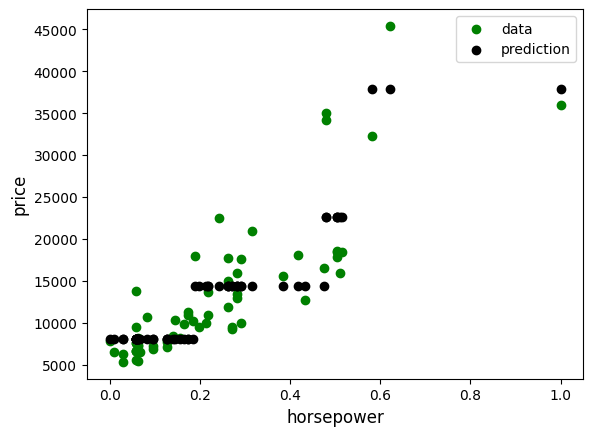

In [77]:
X2 = X_test["horsepower"].values[:,np.newaxis]
y2 = y_test.values

model2 = DecisionTreeRegressor(max_depth=2)
model2.fit(X2, y2)

plt.scatter(X2, y2, color='g', label='data')
plt.scatter(X2, model2.predict(X2), color='k', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

### Регрессия случайного леса

In [83]:
from sklearn.ensemble import RandomForestRegressor

# Create a stepwise regression model
modelRF = RandomForestRegressor(max_depth=2, max_leaf_nodes=4)

# Fit the model to the data
modelRF.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelRF.predict(X_test)


_ = Reg_Models_Evaluation_Metrics(modelRF, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  2638.6453
  R2: 0.8975
 Adjusted R2: 0.831
 Cross Validated R2: 0.7962


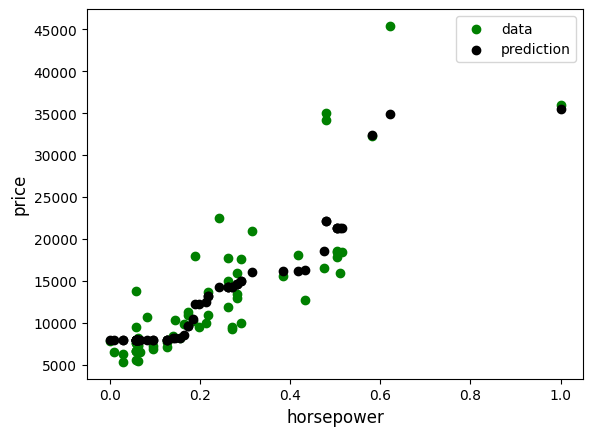

In [82]:
X2 = X_test["horsepower"].values[:,np.newaxis]
y2 = y_test.values

model2 = RandomForestRegressor(max_depth=2, max_leaf_nodes=4)
model2.fit(X2, y2)

plt.scatter(X2, y2, color='g', label='data')
plt.scatter(X2, model2.predict(X2), color='k', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

### Регрессия опорных векторов (SVR)

In [36]:
from sklearn.svm import SVR

#### Линейное ядро

In [37]:
# Create a support vector regression model
modelSVR_L = SVR(kernel='linear')

modelSVR_L.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelSVR_L.predict(X_test)


_ = Reg_Models_Evaluation_Metrics(modelSVR_L, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  8709.7947
  R2: -0.1168
 Adjusted R2: -0.8412
 Cross Validated R2: -0.192


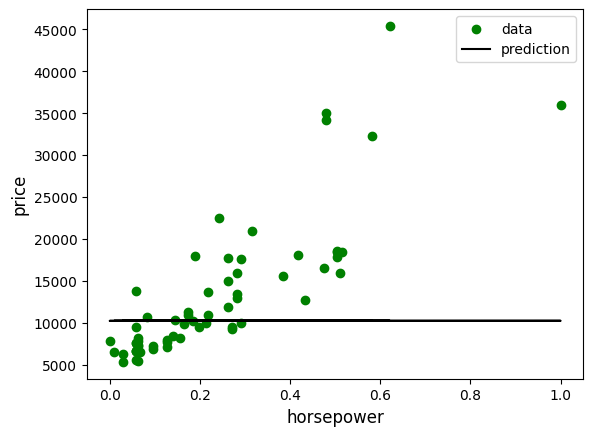

In [38]:
X2 = X_test["horsepower"].values[:,np.newaxis]
y2 = y_test.values

model2 = SVR(kernel='linear')
model2.fit(X2, y2)

plt.scatter(X2, y2, color='g', label='data')
plt.plot(X2, model2.predict(X2), color='k', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

#### Полиномиальное ядро

In [39]:
modelSVR_P = SVR(kernel='poly')

modelSVR_P.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelSVR_P.predict(X_test)


_ = Reg_Models_Evaluation_Metrics(modelSVR_P, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  8237.915
  R2: 0.0009
 Adjusted R2: -0.6471
 Cross Validated R2: -0.0972


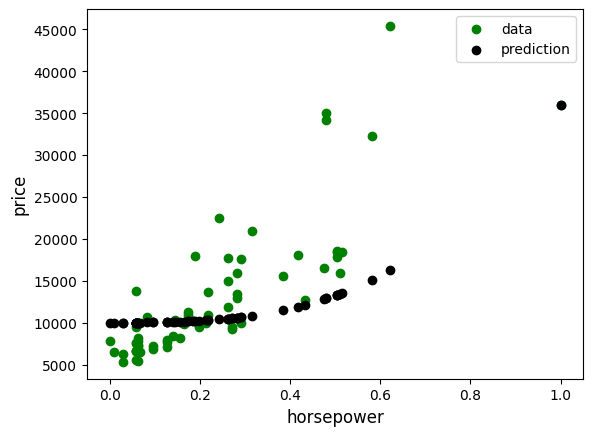

In [67]:
X2 = X_test["horsepower"].values[:,np.newaxis]
y2 = y_test.values

model2 = SVR(kernel='poly')
model2.fit(X2, y2)

plt.scatter(X2, y2, color='g', label='data')
plt.scatter(X2, model2.predict(X2), color='k', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

#### Ядро радиальной базисной функции

In [41]:
modelSVR_R = SVR(kernel='rbf')

modelSVR_R.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelSVR_R.predict(X_test)


_ = Reg_Models_Evaluation_Metrics(modelSVR_R, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  8742.1727
  R2: -0.1251
 Adjusted R2: -0.8549
 Cross Validated R2: -0.1988


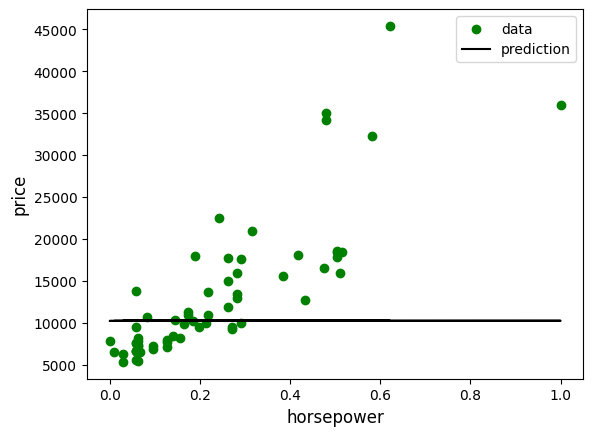

In [42]:
X2 = X_test["horsepower"].values[:,np.newaxis]
y2 = y_test.values

model2 = SVR(kernel='rbf')
model2.fit(X2, y2)

plt.scatter(X2, y2, color='g', label='data')
plt.plot(X2, model2.predict(X2), color='k', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

### Регрессия ElasticNet

In [43]:
from sklearn.linear_model import ElasticNet

#### Частный случай. Регрессия Риджа



In [52]:
# Create an elastic net regression model
modelEN = ElasticNet(alpha=0.0, l1_ratio=0.0)

# Fit the model to the data
modelEN.fit(X_train, y_train)

# Predict the response for a new data point
y_en_pred = modelEN.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelEN, X_train, y_train, X_test, y_test, y_en_pred)

RMSE:  4307.2003
  R2: 0.7269
 Adjusted R2: 0.5497
 Cross Validated R2: 0.7684


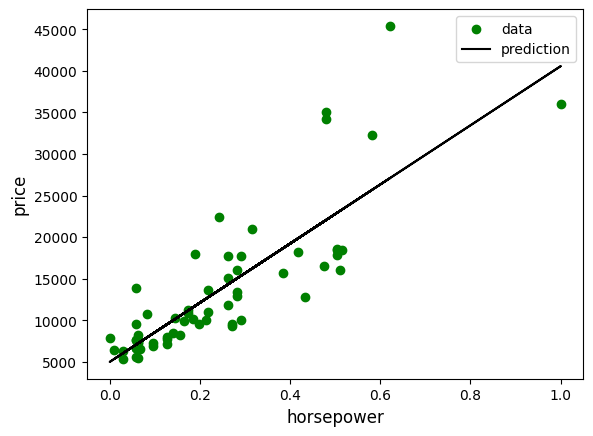

In [46]:
X2 = X_test["horsepower"].values[:,np.newaxis]
y2 = y_test.values

model2 = ElasticNet(alpha=0.0, l1_ratio=0.0)
model2.fit(X2, y2)

plt.scatter(X2, y2, color='g', label='data')
plt.plot(X2, model2.predict(X2), color='k', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

#### Частный случай. Регрессия Лассо

In [53]:
# Create an elastic net regression model
modelEN = ElasticNet(alpha=0.01, l1_ratio=1.0)

# Fit the model to the data
modelEN.fit(X_train, y_train)

# Predict the response for a new data point
y_en_pred = modelEN.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelEN, X_train, y_train, X_test, y_test, y_en_pred)

RMSE:  4306.9457
  R2: 0.7269
 Adjusted R2: 0.5498
 Cross Validated R2: 0.7685


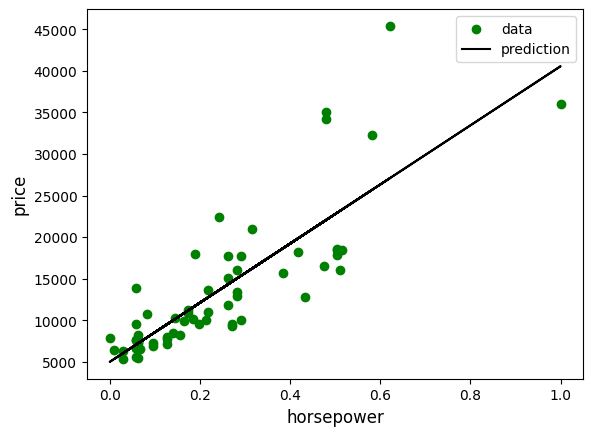

In [55]:
X2 = X_test["horsepower"].values[:,np.newaxis]
y2 = y_test.values

model2 = ElasticNet(alpha=0.01, l1_ratio=1.0)
model2.fit(X2, y2)

plt.scatter(X2, y2, color='g', label='data')
plt.plot(X2, model2.predict(X2), color='k', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

#### Общий случай

In [65]:
# Create an elastic net regression model
modelEN = ElasticNet(alpha=0.1, l1_ratio=0.7)

# Fit the model to the data
modelEN.fit(X_train, y_train)

# Predict the response for a new data point
y_en_pred = modelEN.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelEN, X_train, y_train, X_test, y_test, y_en_pred)

RMSE:  3151.8438
  R2: 0.8538
 Adjusted R2: 0.7589
 Cross Validated R2: 0.7427


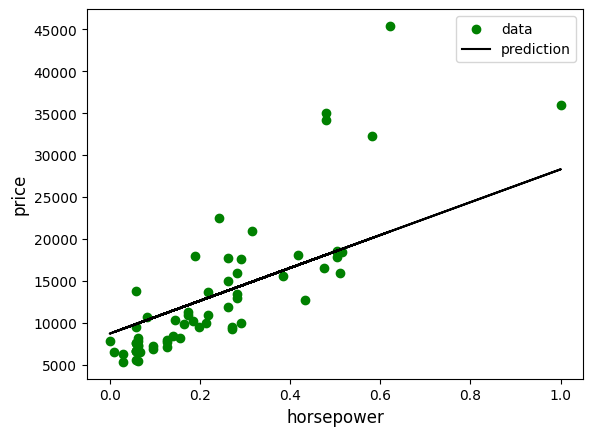

In [66]:
X2 = X_test["horsepower"].values[:,np.newaxis]
y2 = y_test.values

model2 = ElasticNet(alpha=0.1, l1_ratio=0.7)
model2.fit(X2, y2)

plt.scatter(X2, y2, color='g', label='data')
plt.plot(X2, model2.predict(X2), color='k', label='prediction')
plt.ylabel('price', size=12)
plt.xlabel('horsepower', size=12)
plt.legend()
plt.show()

**Вывод:  
Параметры подбирались в ручную.  
Коэффициент детерминации в этом случие получился больше 0.85 (при alpha=0.1, l1_ratio=0.7)**

## Итоги

Модель регрессии опорных векторов плохо работает на взятых данных.  

Хорошо себя показали: Линейная регрессия, регрессия ElasticNet, дерева принятия решений и случайного леса.